<a href="https://colab.research.google.com/github/HenryLiu0405/Stock-Price-Prediction/blob/main/Stock_Price_Predition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [4]:
#open to browse the file
from google.colab import files
uploaded = files.upload()

Saving HistoricalData.csv to HistoricalData.csv


In [5]:
#content
import pandas as pd # Import the pandas library
Filename = 'HistoricalData.csv'
df = pd.read_csv(Filename)  #utf-8

# Pre-treatment

Bsic data cleaning

In [6]:
# Remove duplicate rows if any
df.drop_duplicates(inplace=True)

# Check for missing values and drop rows with NaN
df.dropna(inplace=True)

# Convert columns with mixed types to string first, then remove currency symbols and commas
# Process 'Close/Last', 'Open', 'High', 'Low' columns
for col in ['Close/Last', 'Open', 'High', 'Low']:
    # Convert the entire column to string type
    df[col] = df[col].astype(str)
    # Remove dollar signs and commas
    df[col] = df[col].str.replace('$', '')
    # Convert to float
    df[col] = df[col].astype(float)

# Display the data types after processing
print("\nData types after processing:")
print(df.dtypes)


Data types after processing:
Date           object
Close/Last    float64
Volume          int64
Open          float64
High          float64
Low           float64
dtype: object


Date processing and time feature extraction

In [7]:
# Display the column names of the DataFrame
print("Column names in the DataFrame:")
print(df.columns.tolist())
print(df.head())

Column names in the DataFrame:
['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low']
         Date  Close/Last    Volume     Open      High       Low
0  05/16/2025      454.27  23849780  452.050  454.3600  448.7300
1  05/15/2025      453.13  21992320  450.765  456.1900  450.4301
2  05/14/2025      452.94  19902800  448.140  453.9000  448.1400
3  05/13/2025      449.14  23618820  447.780  450.6733  445.3600
4  05/12/2025      449.26  22821940  445.940  449.3700  439.7800


Technical calculation index

In [8]:
# Feature engineering
# Calculate moving averages
df['close_ma_7'] = df['Close/Last'].rolling(window=7).mean()
df['close_ma_30'] = df['Close/Last'].rolling(window=30).mean()

# Calculate daily return
df['daily_return'] = df['Close/Last'].pct_change()

# Calculate RSI (Relative Strength Index)
delta = df['Close/Last'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate Bollinger Bandsmiddle
middle_band = df['Close/Last'].rolling(window=20).mean()
upper_band = middle_band + 2 * df['Close/Last'].rolling(window=20).std()
lower_band = middle_band - 2 * df['Close/Last'].rolling(window=20).std()

df['middle_band'] = middle_band
df['upper_band'] = upper_band
df['lower_band'] = lower_band

Standardization of features

In [9]:
# Feature scaling
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the 'Close/Last' price and 'Volume'
df[['close_scaled', 'volume_scaled']] = scaler.fit_transform(df[['Close/Last', 'Volume']])

Reprocess missing values

In [10]:
# Drop rows with NaN values resulting from rolling window calculations
df.dropna(inplace=True)

Print data after process

In [11]:
print(df.head())

          Date  Close/Last    Volume     Open    High     Low  close_ma_7  \
29  04/04/2025      359.84  49209850  364.125  374.59  359.48  374.337143   
30  04/03/2025      373.11  30198000  374.785  377.48  369.35  372.237143   
31  04/02/2025      382.14  16092560  377.965  385.08  376.62  371.335714   
32  04/01/2025      382.19  19689500  374.650  382.85  373.23  371.455714   
33  03/31/2025      375.39  35184680  372.535  377.07  367.24  369.298571   

    close_ma_30  daily_return        RSI  middle_band  upper_band  lower_band  \
29   403.485667      0.005533  36.607815     383.3050  425.178487  341.431513   
30   400.780333      0.036878  44.466973     380.1965  414.341329  346.051671   
31   398.414000      0.024202  53.116204     378.0335  404.806341  351.260659   
32   396.055667      0.000131  56.577934     377.3800  402.995422  351.764578   
33   393.597333     -0.017792  57.017166     376.4475  400.837857  352.057143   

    close_scaled  volume_scaled  
29      1.258086

# Prophet for Long Trend

In [12]:
!pip install prophet
from prophet import Prophet

In [13]:
df['Date'] = pd.to_datetime(df['Date'])
df_prophet = df.reset_index()
df_prophet.rename(columns={'index': 'Date'}, inplace=True)

Create a new DataFrame with a date and closing price

In [14]:
prophet_df = df.reset_index()[['Date', 'Close/Last']]
# The column names required for Prophet are 'ds' and' y '
prophet_df.columns = ['ds', 'y']

Initialize Prophet model

In [15]:
model = Prophet(
    yearly_seasonality=True,  # Consider the seasonality of the year
    weekly_seasonality=True,  # Consider the seasonality of the week
    daily_seasonality=False,  # Without considering seasonality, the stock market usually only trades on weekdays
    changepoint_prior_scale=0.5  # adjust trend change points flexibility
)

Fitted model

In [16]:
model.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_vix62q0/sjxzx96m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_vix62q0/jyvtw_6i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36303', 'data', 'file=/tmp/tmp_vix62q0/sjxzx96m.json', 'init=/tmp/tmp_vix62q0/jyvtw_6i.json', 'output', 'file=/tmp/tmp_vix62q0/prophet_modeloz277vzt/prophet_model-20250523084243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Create a future database

            index  Close/Last    Volume     Open    High     Low  close_ma_7  \
Date                                                                           
2025-04-04     29      359.84  49209850  364.125  374.59  359.48  374.337143   
2025-04-03     30      373.11  30198000  374.785  377.48  369.35  372.237143   
2025-04-02     31      382.14  16092560  377.965  385.08  376.62  371.335714   
2025-04-01     32      382.19  19689500  374.650  382.85  373.23  371.455714   
2025-03-31     33      375.39  35184680  372.535  377.07  367.24  369.298571   

            close_ma_30  daily_return        RSI  middle_band  upper_band  \
Date                                                                        
2025-04-04   403.485667      0.005533  36.607815     383.3050  425.178487   
2025-04-03   400.780333      0.036878  44.466973     380.1965  414.341329   
2025-04-02   398.414000      0.024202  53.116204     378.0335  404.806341   
2025-04-01   396.055667      0.000131  56.577934     3

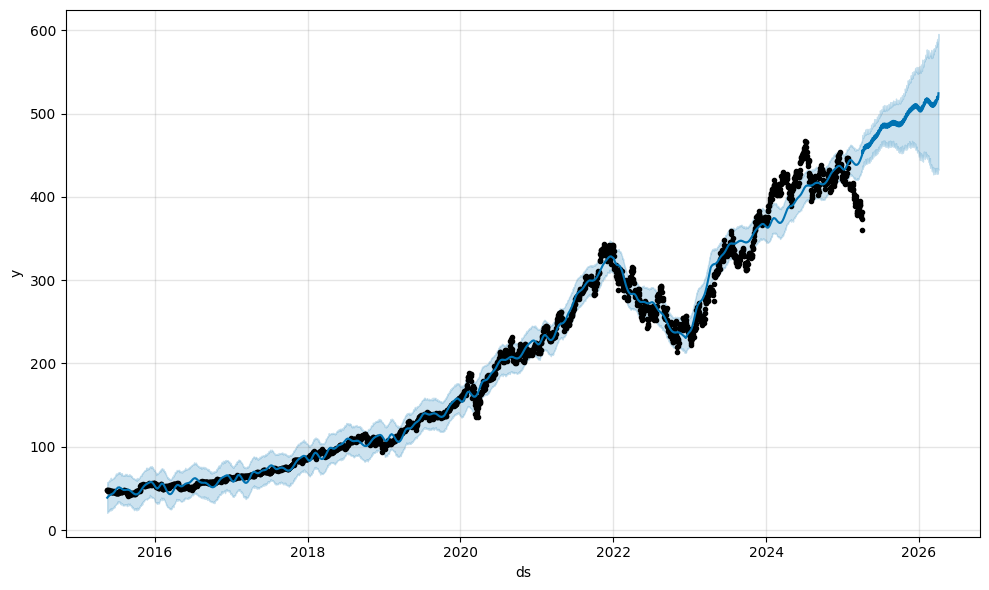

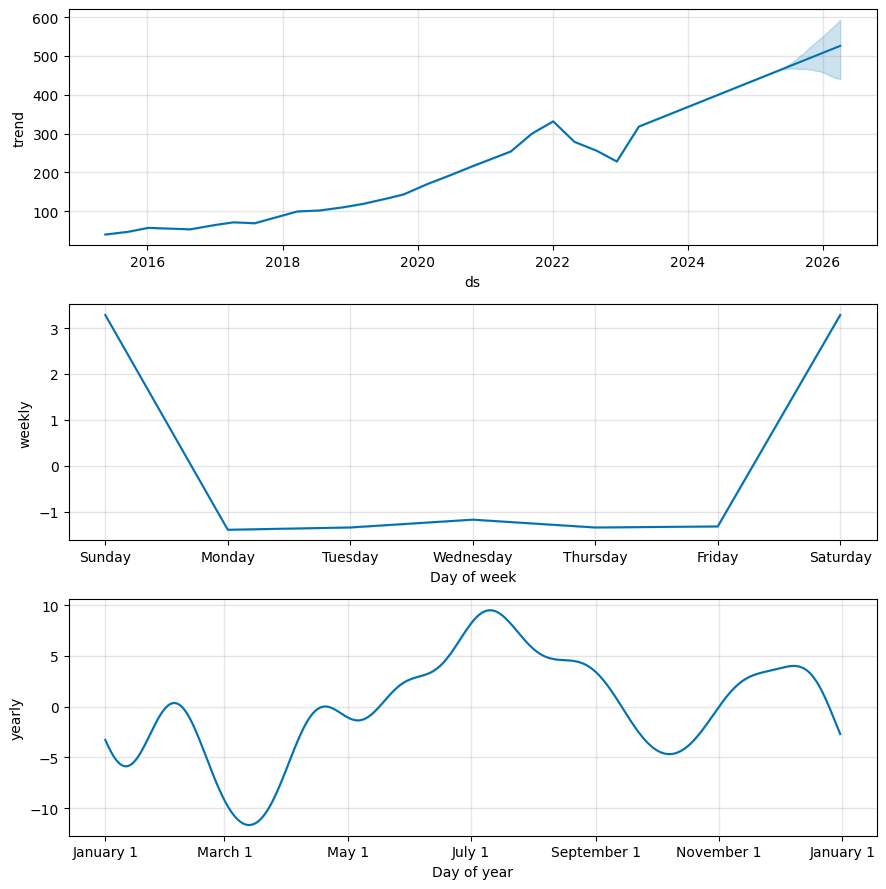

In [17]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future) # predict

# extract trend and seasonality items
trend = forecast[['ds', 'trend']]
seasonality = forecast[['ds', 'yearly', 'weekly']]

# Merge trends and seasonal items
prophet_features = pd.merge(trend, seasonality, on='ds')
prophet_features.rename(columns={'yearly': 'yearly_seasonality', 'weekly': 'weekly_seasonality'}, inplace=True)

# Merge the features extracted by Prophet into the original data box
df_prophet = pd.merge(df.reset_index(), prophet_features, left_on='Date', right_on='ds')
df_prophet.set_index('Date', inplace=True)
df_prophet.drop('ds', axis=1, inplace=True)

# Display the merged data box
print(df_prophet.head())

# Visualize Prophet's prediction results and components
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)
plt.show()

# feature fusion

Merge the original features with the features extracted by Prophet

In [18]:
# 确保索引一致
df_merged = df_prophet.copy()

# 显示融合后的数据框
print(df_merged.head())

            index  Close/Last    Volume     Open    High     Low  close_ma_7  \
Date                                                                           
2025-04-04     29      359.84  49209850  364.125  374.59  359.48  374.337143   
2025-04-03     30      373.11  30198000  374.785  377.48  369.35  372.237143   
2025-04-02     31      382.14  16092560  377.965  385.08  376.62  371.335714   
2025-04-01     32      382.19  19689500  374.650  382.85  373.23  371.455714   
2025-03-31     33      375.39  35184680  372.535  377.07  367.24  369.298571   

            close_ma_30  daily_return        RSI  middle_band  upper_band  \
Date                                                                        
2025-04-04   403.485667      0.005533  36.607815     383.3050  425.178487   
2025-04-03   400.780333      0.036878  44.466973     380.1965  414.341329   
2025-04-02   398.414000      0.024202  53.116204     378.0335  404.806341   
2025-04-01   396.055667      0.000131  56.577934     3

# LSTM & Random Forest

Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [20]:
# prepare data
X = df_prophet.drop('Close/Last', axis=1)
y = df_prophet['Close/Last']

In [21]:
# Divide the training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [22]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [23]:
# predict
y_pred_rf = rf_model.predict(X_test)

# evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Model Evaluation：")
print(f"mean squared error (MSE): {mse_rf}")
print(f"root mean square error (RMSE): {rmse_rf}")
print(f"coefficient of determination (R2): {r2_rf}")

Model Evaluation：
mean squared error (MSE): 214.77213220152444
root mean square error (RMSE): 14.655106011268716
coefficient of determination (R2): -3.735431360464686


LSTM (Long-Short Term Memory)

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import numpy as np

In [30]:
# Convert the dataset into a format suitable for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [31]:
# 设置时间步长
time_steps = 30

# 创建LSTM数据集
X_lstm = df_merged.drop(['Close/Last'], axis=1)
y_lstm = df_merged['Close/Last']

# 划分训练集和测试集
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42, shuffle=False)

# 创建LSTM数据集
X_lstm_train, y_lstm_train = create_dataset(X_lstm_train, y_lstm_train, time_steps)
X_lstm_test, y_lstm_test = create_dataset(X_lstm_test, y_lstm_test, time_steps)

In [36]:
# 构建LSTM模型
lstm_model = Sequential()
# 添加输入层
lstm_model.add(Input(shape=(time_steps, X_lstm_train.shape[2])))

# first layer
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, X_lstm_train.shape[2])))
lstm_model.add(Dropout(0.2))

# Second layer
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))

# connected layer
lstm_model.add(Dense(units=25))
lstm_model.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
# 编译模型
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# 拟合模型
lstm_model.fit(X_lstm_train, y_lstm_train, epochs=500, batch_size=32, validation_split=0.1)

Epoch 1/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 68931.6875 - val_loss: 2312.1936
Epoch 2/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 53511.1211 - val_loss: 56.8327
Epoch 3/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 37759.0234 - val_loss: 2717.0886
Epoch 4/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 23138.6699 - val_loss: 10301.3252
Epoch 5/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14541.0479 - val_loss: 19272.2480
Epoch 6/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12042.2861 - val_loss: 25460.0312
Epoch 7/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 11735.9092 - val_loss: 27734.1816
Epoch 8/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 11855.1826 - val_loss: 28838.0332
Epoch 9/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11735.3535 - val_loss: 29299.6152
Epoch 10/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11677.2754 - val_loss: 29243.8613
Epoch 11/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11931.8740

In [38]:
# 进行预测
y_pred_lstm = lstm_model.predict(X_lstm_test)

# 评估模型
mse_lstm = mean_squared_error(y_lstm_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_lstm_test, y_pred_lstm)

print(f"LSTM模型评估：")
print(f"均方误差 (MSE): {mse_lstm}")
print(f"均方根误差 (RMSE): {rmse_lstm}")
print(f"决定系数 (R2): {r2_lstm}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
LSTM模型评估：
均方误差 (MSE): 38044.17432035471
均方根误差 (RMSE): 195.04915872762618
决定系数 (R2): -989.4816587632691
